#Clustering
Noah Armsworthy<br>
August 16, 2022

##Our Synthetic Dataset
To best understand the benefits and shortcomings of the model, creation of a synthetic dataset will allow us to evaluate based on cluster shape and density.

For our clusters we'll use a normal distribution with a standard deviation of 1 and vary the mean. Finally we'll use a covarience matrix to skew the shape of the second two. (I also intentionally created overlap)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Picked a seed for reproducable testing
np.random.seed(64)
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn')

In [2]:
# Means and standard deviation
mu1, mu2, mu3, sigma = 0, -2, 10, 1 
#Number of data points
pointNum = 1000
#Clusters
c1 = np.random.normal(mu1, sigma, size=(pointNum, 2))
c2 = np.random.normal(mu2, sigma, size=(pointNum, 2))
c3 = np.random.normal(mu3, sigma, size=(pointNum, 2))

'''
Covarience matrix = [Cov(x,x),  Cov(x,y),
                    Cov(y,x),  Cov(y, y)]

Covarience between a variable an itself is called its varience.
Cov(x,x) = Var(x)
Cov(y,y) = Var(y)
Cov(x,y) should be the same as Cov(y,x)
'''

cov2 = [[6, 4], 
        [4, 1]]
c2 = np.dot(c2, cov2)

cov3 =  [[4, -3], 
        [-3, 1]]

c3 = np.dot(c3, cov3)

In [3]:
#Measuring varience in clusters helps with evaluation
print(c2[:2])
meanP = np.array([np.mean(c2[0]), np.mean(c2[1])])
print('The mean point:',meanP)
print(c2[:2] - meanP)
print((np.sum(c2 - meanP)**2)/len(c2))

[[-30.28515868 -14.5928976 ]
 [-21.45028426 -12.18348201]]
The mean point: [-22.43902814 -16.81688313]
[[-7.84613054  2.22398553]
 [ 0.98874388  4.63340113]]
89053.16465899754


In [4]:
import statistics
print("Variance of x is {}".format(statistics.variance(c2[:,0].tolist())))
print("Variance of y is {}".format(statistics.variance(c2[:,1].tolist())))

Variance of x is 52.04985227467941
Variance of y is 17.10592063844082


We are able to easily mark the 3 difference clusters below because we created them ourselves, but it's important to understand that these unsupervised models are meant to work with all the unlabeled data at once and attemps to group them algorithmically.

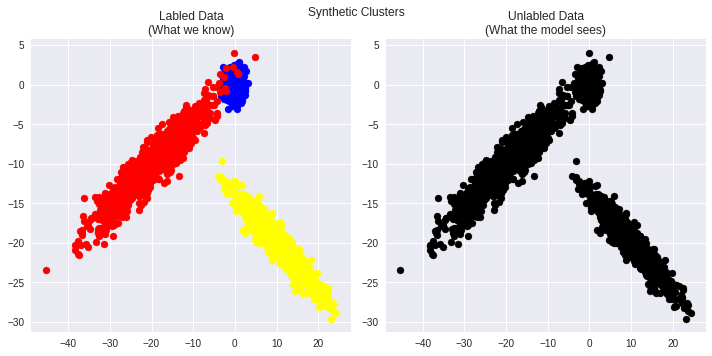

In [26]:
data = np.concatenate((c1, c2, c3))
#Scattor plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.scatter(c1[:,0], c1[:,1], c='blue')
ax1.scatter(c2[:,0], c2[:,1], c='red')
ax1.scatter(c3[:,0], c3[:,1], c='yellow')
ax1.set_title('Labled Data\n(What we know)')
ax2.scatter(data[:,0], data[:,1], c='black')
ax2.set_title('Unlabled Data\n(What the model sees)')
fig.suptitle('Synthetic Clusters')
fig
fig.tight_layout()
plt.show()

##KMeans Clustering

We start by defining how we will measure the relationship between two points. The simplest method is simply measuring the distance (AKA Euclidean distance) between the two.

In [7]:
#Euclidean distance
def point_distance(point1, point2):
  return np.sqrt( (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

###Our model
We are beginning our model by assuming we know that we're looking for 3 distinct clusters. 

<b>Summary of training the model:</b><br>
We will fit the model by telling it how many clusters (K) we believe there are, and the max iterations to run. It will begin by selecting a K amount of random points from the data and assigning them the identity of <b>centroid</b> (the central point of the cluster). 

Then, for every point in the data, it will measure that point's distance to each centroid. That point will be assigned to the cluster group represented by the closest centroid. 

Once all points are assigned, we caculate a new centroid for each cluster by finding the average of all points in the cluster. This will give us a point in the center of each cluster. We will then recalculate each points distances to centroids and re-assign them to the closest one. 

This process is repeated for a pre-defined number of iterations or until convergence is reached within a certain value of decimal places. 

To measure convergence, we check to see if the distance between the previous centroids and the new ones is unmeasurable within the decimal places defined by the convergence value. (convVal = 2, looking for changes within 2 decimal places: 0.00)


In [43]:
class Clustering:
  #Data given for first centroid random indexing
  #A convergence value can be set, I chose to default to 2 (checks convergence within 2 decimal places)
  def __init__(self, nclusters, niter, convVal = 2):
    if nclusters <= 0:
      print('You must select a cluster number(k) greater than 0')
      return
    self.X = None
    self.centroids = []
    self.labels = []
    self.nclusters = nclusters
    self.niter = niter
    self.totaliter = 0
    self.convVal = convVal

  #Training
  def fit(self, X, plot = False):
    conv = False
    self.X = X
    #Randomly select ncluster indices of X for random centroids initialization
    for i in range(0, self.nclusters):
      ranInd = np.random.randint(len(X))
      self.centroids.append(list(X[ranInd]))
    
    #Clusters will be stored as lists of lists starting with the centroid point
    #These lists are to keep track of points in each cluster for averaging
    self.clusters = [[list(x)] for x in self.centroids]

    totaliter = 0
    #Fit will run either the given iteration amount or until convergence is reached
    while(totaliter <= self.niter and conv == False): 
      #Clear the labels generated last time
      self.labels.clear()
      #Clearing the lists tracking where the datapoints belong
      self.__clearClusters()

      #For each data point, calculate the relative distances to each centroid
      for i in range(0, len(X)):
        distances = []
        for centroid in self.centroids:
          distances.append(point_distance(X[i], centroid))
        
        #Index of the closest centroid
        ind = np.argmin(distances)
        self.labels.append(ind)
        #Add it to that cluster's list of data points
        self.clusters[ind].append(list(X[i]))

      #Show plot for  visualization
      if plot:
        self.plot_clusters()
      
      newCentroids = []
      for i in range(0, len(self.centroids)):
        #Get the average point from all datapoints in relevant cluster
        #Excluding centroid stored at index 0
        #Need to convert cluster list to np.array for the averaging of x & y values
        avgx = np.average(np.array(self.clusters[i])[1:,0])
        avgy = np.average(np.array(self.clusters[i])[1:,1])
        avg = [avgx, avgy]
        newCentroids.append(avg)
        
        #Replace centroid value at start of cluster list for if we continue
        self.clusters[i][0] = avg
      
      #The last value here is the criterion for convergence
      conv = self._converged(self.centroids, newCentroids, self.convVal)
      self.centroids = newCentroids
      totaliter += 1

    #After while loop, print how many iterations were run and whether we converged
    print(f"Ran for {totaliter} iterations.\nConvergence reached: {conv}")

  ''' This predict function can be used after training is complete to tell you which cluster 
  a new set of points belongs to in its current configuration. It will be based on the closest centroid.
  '''
  def predict(self, X):
    predList = []
    #Loop through the given data points
    for i in range(0, len(X)):
      #Get distances to all centroids
        distances = []
        for centroid in self.centroids:
          distances.append(point_distance(X[i], centroid))
        
        #Index of the closest centroid
        ind = np.argmin(distances)
        #Add to the equal sized prediction list
        predList.append(ind)
    return predList

  #Clearing the stored clusters for reassignment
  def __clearClusters(self):
    self.clusters.clear()
    self.clusters = [[list(x)] for x in self.centroids]

  def get_centroids(self):
    return self.centroids
  
  #Plotting the clusters and their centroids
  def plot_clusters(self):
    cent = np.array(self.centroids)
    #Seaborn makes label legend automatically
    sns.scatterplot(x=self.X[:,0], y=self.X[:, 1], hue=self.labels, style=self.labels, palette='tab10')
    plt.scatter(cent[:,0], cent[:,1], c='red', label='Centroids')
    plt.legend()
    plt.show()

  #Compare the distance difference between centroids within defined constraints
  def _converged(self, currCent, newCent, roundVal):
    result = [0 for x in currCent]
    for i in range(0, len(currCent)):
      #Get the values for centroid comparison
      #These will be rounded by the convergence value
      cent1 = [round(x, roundVal) for x in currCent[i]]
      cent2 = [round(x, roundVal) for x in newCent[i]]

      #If the rounded x and y values are the same
      if cent1[0] == cent2[0] and cent1[1] == cent2[1]:
        result[i] = 1


    #If all result values are 1, we've converged (adding up add 1's will equal the length of the array)
    return np.sum(result) == len(result)

  '''This performance measure works on the assumption that we know the correct spread of clusters.
  This is only used for analysis on the model and other performance metrics are required 
  for a real 'unsupervised' example.'''
  def getKnownError(self, pointNum):
    totalErr = 0
    for cluster in self.clusters:
      #Each cluster had 1000 data points in our example.  
      #Get difference of stored clusters -1 for the leading centroid point
      totalErr += np.absolute(pointNum - (len(cluster) - 1))

    print("Incorrectly classified point count:",totalErr)
    print("Data point count per cluster:")
    for i in range(0, len(myClustering.clusters)):
      print(i, ':', len(myClustering.clusters[i])-1)

  


I chose to use the index of each centroid within a list to represent it's 'label', so the clusters are assigned integer names from 0 onward.

Plotting the results after each iteration helps us visualize the clustering process.

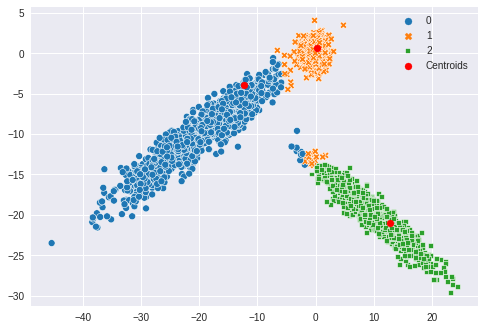

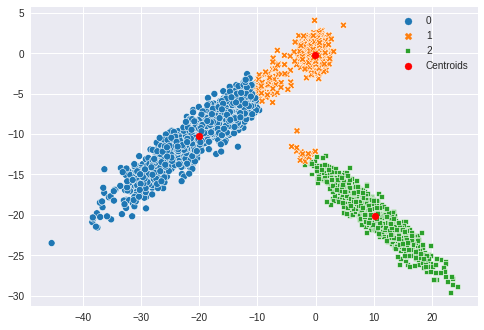

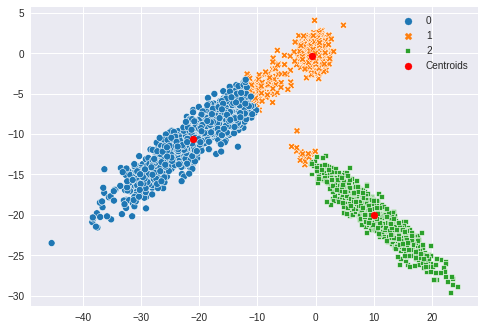

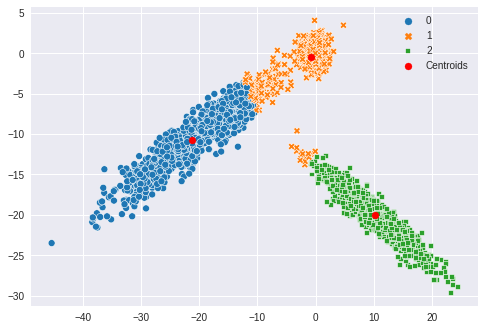

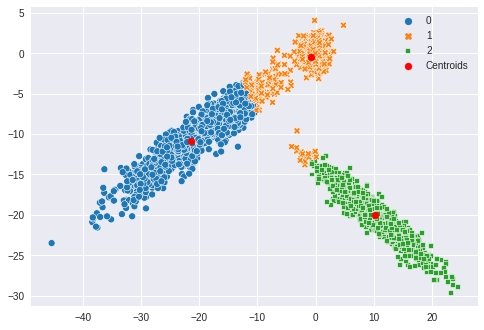

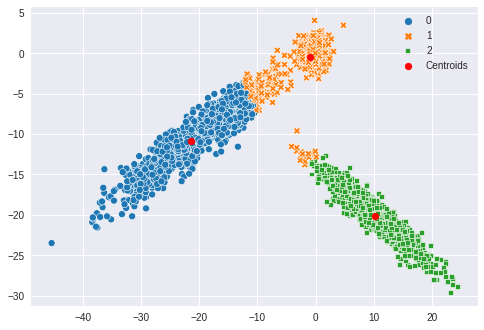

Ran for 6 iterations.
Convergence reached: True


In [44]:
#Initialize the clustering class/model
myClustering3 = Clustering(3,15)
#Fit it to the data (Data, # of clusters, # of iterations)
myClustering3.fit(data,plot=True)

###How to pick K? / Evaluation

In real-world scenarios, we might not know the number of distinct groups we are looking for so how do we pick a value for K to hand to the model? Also, without knowing how many clusters there hsould be, how do we evaluate the perfomance of the model?

The simplest way to find K is to run through many possible values and evaluate the models performance on each run.

Using the function we made above knowing the that each cluster has 1000 data points, we can loop through and see how many points are incorrectly classified by the model:

In [10]:
for i in range(1,6):
  print("Running model with {} clusters".format(i))
  #Initialize the clustering class/model
  myClustering = Clustering(i,15)
  #Fit it to the data (Data, # of clusters, # of iterations)
  myClustering.fit(data)
  myClustering.getKnownError(pointNum)
  print('\n')

Running model with 1 clusters
Ran for 2 iterations.
Convergence reached: True
Incorrectly classified point count: 2000
Data point count per cluster:
0 : 3000


Running model with 2 clusters
Ran for 7 iterations.
Convergence reached: True
Incorrectly classified point count: 1104
Data point count per cluster:
0 : 948
1 : 2052


Running model with 3 clusters
Ran for 6 iterations.
Convergence reached: True
Incorrectly classified point count: 262
Data point count per cluster:
0 : 984
1 : 885
2 : 1131


Running model with 4 clusters
Ran for 4 iterations.
Convergence reached: True
Incorrectly classified point count: 1132
Data point count per cluster:
0 : 986
1 : 507
2 : 1066
3 : 441


Running model with 5 clusters
Ran for 16 iterations.
Convergence reached: False
Incorrectly classified point count: 2080
Data point count per cluster:
0 : 349
1 : 419
2 : 207
3 : 1040
4 : 985




Above you can see that K=3 has a significantly lower error than other options.

However, we mentioned above that we might not know how many clusters there are or how many points belong to each cluster. We need a standard metric for cluster interpretation such as Silhouette Score, which returns a value for how well each point has been grouped by your model.

Silhouette score validates by first measuring the similarity within a cluster by the relationship between each point and all other points in its assigned cluster. Next, we measure the relationship between a point and all points in each other cluster. The smallest mean distance to a cluster is categorized as the smallest dissimilarity, also the second most likely cluster this point would be assigned to. These relationships are calculated using Euclidean Distance defined above.

Finally, the silhouette equation breaks down to:<br>
$silhouette(point)=\frac{dissimilarity\_score(point) - similarity\_score(point)}{max(dissimilarity\_score(point) , similarity\_score(point))} $<br>
(See https://en.wikipedia.org/wiki/Silhouette_(clustering) for a more detailed breakdown of the calculations)


The final mean silhouette score over all data in the dataset is returned and a value close to 1 means the data is clustered effectively.


In [15]:
'''
The Silhouette Score function to interpret the consistency of clusters withjin the data.

Using Euclidean Distance, each point will have their intra-cluster similiarity (a) and nearest inter-cluster disimilarity (b) evaluated.

s = b(point) - a(point) / max{a(point), b(point)}

A value close to 1 means points tend to be well matched to their cluster and poorly matched to its neighboring cluster. (Well classified)
'''
def SilhouetteScore(clusterModel):
  numC = len(clusterModel.clusters)
  #We can only calculate silhouette if there are neighboring clusters to compare
  if numC <= 1:
    print('Silhouette score calculations require at least 2 clusters')
    return None,None

  #All silhouette scores
  allS = []

  #i loops through the clusters
  for i in range(0,numC): 
    currClust = np.asarray(clusterModel.clusters[i][1:]) #exclude centroid
    
    #j loops through all points in a cluster
    for j in range(0, len(currClust)): 
      #The current point we are working with
      currP = np.asarray(currClust[j])
      numOtherP = len(currClust) - 1 #-1 to exclude the current point from the cluster points count
      
      #Euclidean distances within the same cluster (distance to the same point is 0, contributes nothing)
      #First you must sum the squared x,y distance values row by column (axis=1), then apply the root
      allEDInC = np.sqrt(np.sum(np.square(currClust-currP), axis=1, keepdims=True))
      #The smaller the better
      a = np.sum(allEDInC)/numOtherP

      #For this point, calculate mean distance to all other points in other clusters
      #Only if there are more than one cluster
      allB = []
      
      for k in range(0, numC): #Other clusters
        if k != i: #Not the current cluster
          currDiffC = np.asarray(clusterModel.clusters[k][1:]) #Excluding centroid
          allEDOutC = np.sqrt(np.sum(np.square(currDiffC - currP), axis=1, keepdims=True)) #All Euclidean distances
          #Add this mean distance to the list
          allB.append(np.sum(allEDOutC/len(currDiffC))) 
      
      #The minimum found mean distance is the closest neighboring cluster (next best fit)
      b = min(allB) 
      
      #Silhouette score of this point
      s = (b - a)/max(a,b) 
      #Store it
      allS.append(s)
    
  #The final silhouette coefficient is the mean value of all found s
  return np.mean(allS), allS

It's not ideal to have a triple nested loop above, but we're doing it this way for clarity of the steps in this calculation. Speed and complexity optimizations could be done from here such as using distance matrices for the a & b calculations. 

Below we can see what our Silhouette function returns along with the compared result from the Scikit Learn library for validity. 

In [16]:
from sklearn.metrics import silhouette_score
#Our function
meanS , sData = SilhouetteScore(myClustering3)
print('Our calculated Silhouette Score (k=3):', meanS)

#Running the sklearn Silhouette function with our trained labels
labels = myClustering3.labels
print(f'Sklearn\'s Silhouette Score with our labels(k=3): {silhouette_score(data, labels)}')

Our calculated Silhouette Score (k=3): 0.7199270683120018
Sklearn's Silhouette Score with our labels(k=3): 0.7199270683120018


####Looping through silhouette scores

Now that we have a method of evaluating our Cluster model's performance, we can see how you might choose a value for k if the number of clusters were unknown. 

This can be done by simply running this calculation for varying k values and selecting the one with the highest Silhouette Score. This comparison should also be run a few times due to the randomness of KMeans initialization.

In [22]:
for i in range(1,6):
  print("Running model with {} clusters".format(i))
  #Initialize the clustering class/model
  myClustering = Clustering(i,15)
  #Fit it to the data (Data, # of clusters, # of iterations)
  myClustering.fit(data)
  sScore, sAll = SilhouetteScore(myClustering)
  print("Silhouette score of k = {}:{}".format(i, sScore))
  print('\n')

Running model with 1 clusters
Ran for 2 iterations.
Convergence reached: True
Silhouette score calculations require at least 2 clusters
Silhouette score of k = 1:None


Running model with 2 clusters
Ran for 7 iterations.
Convergence reached: True
Silhouette score of k = 2:0.5522388106432432


Running model with 3 clusters
Ran for 6 iterations.
Convergence reached: True
Silhouette score of k = 3:0.7199270683120019


Running model with 4 clusters
Ran for 16 iterations.
Convergence reached: True
Silhouette score of k = 4:0.6886041167103218


Running model with 5 clusters
Ran for 15 iterations.
Convergence reached: True
Silhouette score of k = 5:0.642741772372247




Above you can see that the silhouette score closest to 1 is achieved when our model is given 3 for the value of k.

###Predictions
Now that we are happy with our model's performance given the best found value for k, we can use the trained model to tell us which cluster a new data point is likely to belong to. 

In [18]:
test = [[0.0, 1.0], [5.0, 5.0], [-10.0, -10.0], [15.0, 4.0], [20.0, -10.0]]
clusterPred = myClustering3.predict(test)
print(clusterPred)

[1, 1, 0, 1, 2]


###Scikit Learn
To validate our model, we can compare performance to the KMeans model from the Scikit Learn library.

This obvious requires much less code to create, but is much less clear about what calculations and functions are being performed during initialization and training.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3).fit(data)
print(kmeans.labels_)
print(kmeans.cluster_centers_)


[0 0 0 ... 2 2 2]
[[ -0.88089626  -0.53239367]
 [-21.41137277 -10.84287117]
 [ 10.15304099 -20.07661931]]


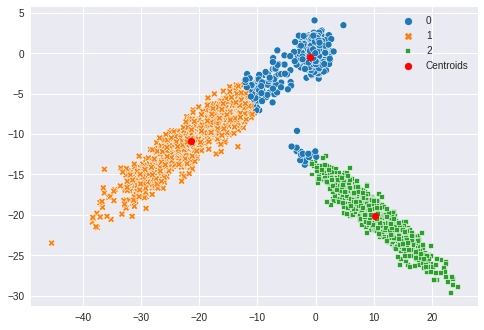


Sklearn's Silhouette Score(k=3): 0.7199270683120018


In [21]:
#Plotting the data for the visual comparison
sns.scatterplot(x=data[:, 0], y=data[:,1], hue=kmeans.labels_, style=kmeans.labels_, palette='tab10')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', label='Centroids')
plt.legend()
plt.show()

#With their labels
print(f'\nSklearn\'s Silhouette Score(k=3): {silhouette_score(data, kmeans.labels_)}')

As you can see, at least for this collection of data, our model performs exactly the same as the sklearn model. The same silhouette score is returned.

###Problems with Kmeans
Now that we are happy with how our model, we can easily see the issues with choosing KMeans for clustering our data.

The randomization of the starting point of the centroids, its easy to have a bad initialization, requiring multiple runs of the same training data to seek the best fit.

The simplicity of mean euclidean distances in every direction, you will always end up with circular shaped clusters. This can cause difficulty with clusters who are too close together or clusters that are different shapes like the rightmose cluster in our example who's top tip is included in the wrong cluster.

There is also the issue of having to either know your hyperparameter k value or having to run tests with evaluation metrics to find the one that is the most *likely* be the appropriate.

####Other Datasets
Here we can see a different dataset that should be simple for kmeans due to its circular shaped clusters.
However, due to the proximity of the clusters and the issue with randomized initial centroids, you will often see it fall short in grouping our clusters properly.
https://cs.joensuu.fi/sipu/datasets/

In [45]:
asymData = np.genfromtxt('https://cs.joensuu.fi/sipu/datasets/asymmetric.txt',delimiter=' ')
print(asymData [:5])
#Normalizing the data
maxValues = np.max(asymData , axis=0)
minValues = np.min(asymData , axis=0)
asymData  = (asymData  - minValues) / (maxValues - minValues)
print(data[:5])

[[2128. 2317.]
 [1794. 2522.]
 [3087. 2482.]
 [3174. 2492.]
 [3408. 2718.]]
[[ 1.10032294 -1.98262742]
 [-1.15024951  2.19291636]
 [-1.90143503 -0.43389669]
 [-1.13558187 -1.03329507]
 [-2.37195862  0.70333809]]


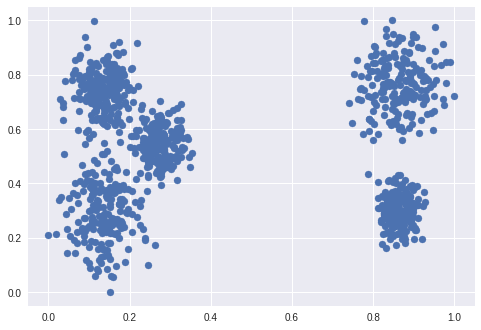

In [28]:
plt.scatter(asymData[:,0],asymData[:,1])

Run the code below to see how often KMeans struggles to identify the 5 clusters properly.

Ran for 4 iterations.
Convergence reached: True


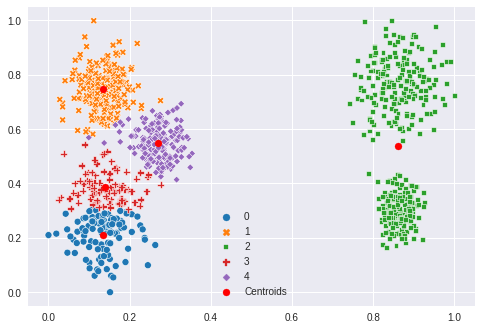

My silhouette score: 0.5322342461377104


In [52]:
myClustering5 = Clustering(5,15)
#Fit it to the data (Data, # of clusters, # of iterations)
myClustering5.fit(asymData)
myClustering5.plot_clusters()
print('My silhouette score:',SilhouetteScore(myClustering5)[0])

#References used

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
https://en.wikipedia.org/wiki/Silhouette_(clustering)
https://www.dabblingbadger.com/blog/2020/2/27/implementing-euclidean-distance-matrix-calculations-from-scratch-in-python
